In [1]:
import numpy as np
import copy
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import ascii
from astropy import wcs
from astropy.io import fits
from astropy.table import QTable, Table, Column,vstack

# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc('mathtext',fontset='stixsans')
#matplotlib.rc_file(\"../../templates/matplotlibrc\")
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
# Astropy Regions (but standalone package installed with pip)
import regions



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def pfs_vertices(ctr_coord,pa=0):
    # Given a field center (SkyCoord object), return the 6 vertices of a Subaru PFS field. Optional PA is in degrees
    d = 41.4*u.arcmin 
    vertices=[]
    for i in range(6):
        angularoffset = np.pi / 3 * i *u.radian + pa*u.deg
        vertices.append(ctr_coord.directional_offset_by(angularoffset,d))
    return SkyCoord(vertices)

Read in the PFS GE pointing centers

In [3]:
ge_fields_in = ascii.read('pfs_ge_fcenter_0724.txt')

fields   = ge_fields_in['fieldname']
subfield = ge_fields_in['subfieldno']
ra_field = ge_fields_in['ra']
dec_field= ge_fields_in['dec']

ctr_coords = SkyCoord(ra=ra_field*u.deg, dec=dec_field*u.deg, frame='icrs')

In [4]:
fieldstr = 'COSMOS'
getfields = fields==fieldstr
ctrs_here = ctr_coords[getfields]
n_pointings=np.sum(getfields)

# Compute a very rough center position for these pointings, as the average of the pointing centers
rough_ctr = SkyCoord(ra=np.mean(ctrs_here.ra.to(u.deg)), dec=np.mean(ctrs_here.dec.to(u.deg)), frame='icrs')

print('Rough center for '+fieldstr+': '+rough_ctr.ra.to_string(u.hour)+rough_ctr.dec.to_string(u.deg,alwayssign=True))

Rough center for COSMOS: 10h00m25.6158s+2d06m28.86588s


Set up WCS for COSMOS field

In [5]:
wcstmp = wcs.WCS(naxis=2)
wcstmp.wcs.crpix=[1,1]
wcstmp.wcs.crval=[148.547008, 0.662545] # eyeballed off hscMap
wcstmp.wcs.cdelt=[0.001666667, 0.00166667]
wcstmp.wcs.ctype = ["RA---TAN", "DEC--TAN"]
wcstmp.wcs.radesys='ICRS'
wcstmp.wcs.equinox=2000.00

ctr1 = ctr_coords[9]

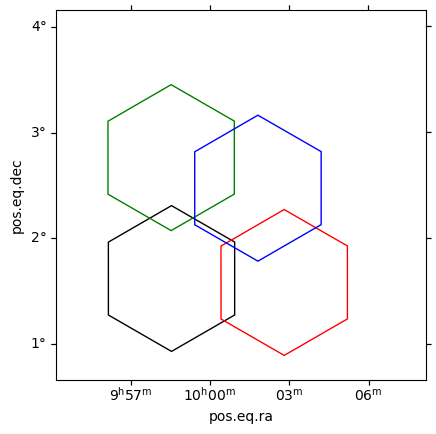

In [6]:
all_regions = []

# Des
pa_list = [0,0,0,0]

# This creates the Regions (i.e. list of regions)
for tmpcoord,pa_tmp in zip(ctr_coords[getfields],pa_list):
    all_regions.append(regions.PolygonSkyRegion(vertices=pfs_vertices(tmpcoord,pa=pa_tmp)))

# This is the composite region of all pointings
for ii in range(n_pointings-1):
    if ii == 0:
        comb_region = all_regions[0]
    comb_region = comb_region | all_regions[ii+1]

pix_reg_allcosmos = comb_region.to_pixel(wcstmp)

colorlist=['black','green','red','blue']

ax=plt.subplot(projection=wcstmp)
ax.set_xlim(0,2100)
ax.set_ylim(0,2100)
for reg_tmp,colortmp in zip(all_regions,colorlist):
    pix_reg_tmp = reg_tmp.to_pixel(wcstmp)
    ax.add_artist(pix_reg_tmp.as_artist(color=colortmp))
ax.set_aspect('equal')


In [7]:
print(rough_ctr.ra.to_string(u.hour)+rough_ctr.dec.to_string(u.deg,alwayssign=True))

10h00m25.6158s+2d06m28.86588s


Read in SDSS DR16 QSO catalog, and make desired cuts

In [8]:
hdulist = fits.open('DR16Q_v4.fits')
#hdulist.info()

qsocat = hdulist[1].data
hdulist.close()

sdssname = qsocat['SDSS_NAME']
ra_qso = qsocat['RA']
dec_qso = qsocat['DEC']
dr16_coords = SkyCoord(ra = ra_qso*u.deg, dec=dec_qso*u.deg, frame='icrs')
z_qso = qsocat['Z']
mag_qso = qsocat['PSFMAG']
gmag_qso = mag_qso[:,1].flatten()
rmag_qso = mag_qso[:,2]
imag_qso =  mag_qso[:,3]

cut_bright = np.all(np.column_stack([(rmag_qso<20.2),(z_qso > 2.4),(z_qso<3.1)] ),axis=1)

sdssname = sdssname[cut_bright]
dr16_coords=dr16_coords[cut_bright]
z_qso = z_qso[cut_bright]
gmag_qso=gmag_qso[cut_bright]
rmag_qso=rmag_qso[cut_bright]
imag_qso=imag_qso[cut_bright]

fieldname_empty = np.full(np.size(z_qso),'        ')
exptime_est = 13.333 * 10.**(0.8*(gmag_qso-20.035)) * 1.**2  # Assuming we want 50% better S/N than Q095938+020450

# Work with this Table moving forward
bright_tab = Table([sdssname,dr16_coords,z_qso,gmag_qso, rmag_qso,imag_qso,fieldname_empty,exptime_est],
                   names=('sdssname','coord','z','gmag','rmag','imag','fieldname','est_exptime'))

dr16_indices = np.arange(np.size(sdssname),dtype=np.int32)

First, make a rough cut in SDSS QSOs within a few deg of the rough field center

In [9]:
d2d = rough_ctr.separation(dr16_coords)
roughmask = d2d < 2.*u.deg
roughind = dr16_indices[roughmask] # this is to keep track of the indices relative to the master catalog

Use the .contains() method in the region object to find QSOs within the field. Need to also pass it a WCS.

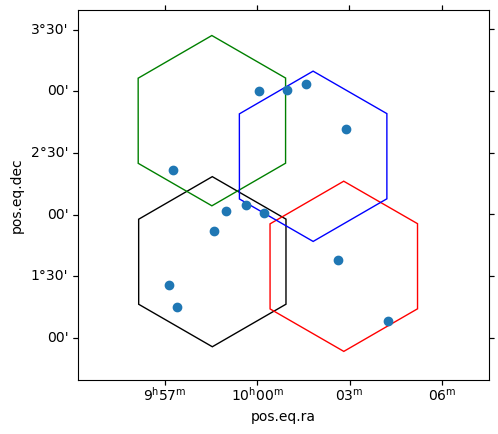

In [10]:
# These indices reference the bright DR16 catalog
indregion = roughind[comb_region.contains(dr16_coords[roughmask],wcstmp)]

xqso, yqso = wcstmp.world_to_pixel(dr16_coords[indregion])

ax=plt.subplot(projection=wcstmp)
ax.set_xlim(0,2000)
ax.set_ylim(0,1800)
for reg_tmp,colortmp in zip(all_regions,colorlist):
    pix_reg_tmp = reg_tmp.to_pixel(wcstmp)
    ax.add_artist(pix_reg_tmp.as_artist(color=colortmp))
ax.set_aspect('equal')
ax.scatter(xqso, yqso)

In [11]:
bright_tab['fieldname'][indregion] = 'COSMOS'
#bright_tab[indregion]

In [12]:
bright_tab[indregion]

sdssname,coord,z,gmag,rmag,imag,fieldname,est_exptime
,"deg,deg",,,,,,
str18,SkyCoord,float64,float32,float32,float32,str8,float32
095708.90+012553.7,"149.28711656790205,1.4316088407598835",2.683,20.241943,20.160286,20.166454,COSMOS,19.520128
095716.14+022137.7,"149.31726149546253,2.3604949011613057",2.788,19.565521,19.40382,19.359564,COSMOS,5.6149383
095723.69+011458.7,"149.34872659077297,1.2496522956500555",2.484,19.775734,19.632545,19.676416,COSMOS,8.2701845
095835.98+015157.0,"149.6499231294211,1.8658445440620242",2.932,19.831593,19.839148,19.470959,COSMOS,9.166469
095858.67+020138.9,"149.74449909675252,2.0274957342689794",2.455,18.946745,18.854816,18.865751,COSMOS,1.7960727
095938.29+020450.0,"149.90954516802452,2.0805786215121533",2.802,20.674732,20.123108,19.811779,COSMOS,43.32253
100003.82+030005.2,"150.01593233887593,3.0014604395016105",2.745,19.984737,19.81777,19.694244,COSMOS,12.153963
100014.13+020054.4,"150.058909,2.015134",2.500277,20.03502,19.750051,19.790524,COSMOS,13.333515


Refactor the above code into a function. This takes in a Table of objects, and figures out if they are within one of the PFS GE fields ('COSMOS', 'DEEP2-3', 'XMMLSS' or 'EN1')

In [13]:
def select_brightqsos(qsotable, fieldname_in='COSMOS', pointinglist='pfs_ge_fcenter_0724.txt',all_pa=0.,plot=True):
    # For select bright QSOs that fall within a given PFS GE Field. 
    # The input qsotable should already be filtered for redshift and magnitude criteria
    # It should have fields: 'sdssname','coord','z','gmag','rmag','imag','fieldname','est_exptime', where coord is a SkyCoord
    # all_pa sets the position angle of the field in degrees. PFS can take only 0 or 90 deg PA
    #
    # Outputs the subset of the input Table that falls within the field
    
    # Read in PFS GE pointing centers, and convert them to SkyCoords
    ge_fields_in = ascii.read('pfs_ge_fcenter_0724.txt')

    fields   = ge_fields_in['fieldname']
    subfield = ge_fields_in['subfieldno']
    ra_field = ge_fields_in['ra']
    dec_field= ge_fields_in['dec']    
    ctr_coords = SkyCoord(ra=ra_field*u.deg, dec=dec_field*u.deg, frame='icrs')

    # Select pointings corresponding to a given field
    getfields = fields==fieldname_in
    ctrs_here = ctr_coords[getfields]
    n_pointings=np.sum(getfields)
    # Compute a very rough center position for these pointings, as the average of the pointing centers
    rough_ctr = SkyCoord(ra=np.mean(ctrs_here.ra.to(u.deg)), dec=np.mean(ctrs_here.dec.to(u.deg)), frame='icrs')
    
    print('Rough center for '+fieldname_in+': '+rough_ctr.ra.to_string(u.hour)+rough_ctr.dec.to_string(u.deg,alwayssign=True))

    # This integer index keeps track of the input QSO table
    dr16_indices = np.arange(np.size(qsotable),dtype=np.int32)
    dr16_coords = qsotable['coord']

    # Make a rough cut of objects that are within a few degrees of the field, to make the matching faster
    d2d = rough_ctr.separation(dr16_coords)
    roughmask = d2d < 2.*u.deg
    roughind = dr16_indices[roughmask] # this still keeps track of the indices relative to the master catalog

    # Set up a WCS for the desired field
    wcstmp = wcs.WCS(naxis=2)
    wcstmp.wcs.crpix=[1000,900]
    wcstmp.wcs.crval=[rough_ctr.ra.to(u.deg).value, rough_ctr.dec.to(u.deg).value] 
    wcstmp.wcs.cdelt=[0.001666667, 0.00166667]
    wcstmp.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    wcstmp.wcs.radesys='ICRS'
    wcstmp.wcs.equinox=2000.00

    # Generate the regions from the PFS pointing centers and create a compound region in both sky and pixel references
    all_regions = []
    
    # This creates the Regions (i.e. list of regions)
    for tmpcoord in ctr_coords[getfields]:
        all_regions.append(regions.PolygonSkyRegion(vertices=pfs_vertices(tmpcoord,pa=all_pa)))
    
    # This is the composite Sky region of all pointings
    for ii in range(n_pointings-1):
        if ii == 0:
            comb_region = all_regions[0]
        comb_region = comb_region | all_regions[ii+1]
    # This is the pixel counterpart
    pix_reg_comb = comb_region.to_pixel(wcstmp)

    # These are QSOs that fall inside the region;  indices reference the bright DR16 catalog
    indregion = roughind[comb_region.contains(dr16_coords[roughmask],wcstmp)]

    if plot is True:
        xqso, yqso = wcstmp.world_to_pixel(dr16_coords[indregion])
        ax=plt.subplot(projection=wcstmp)
        ax.set_xlim(0,2000)
        ax.set_ylim(0,1800)
        for reg_tmp in all_regions:
            pix_reg_tmp = reg_tmp.to_pixel(wcstmp)
            ax.add_artist(pix_reg_tmp.as_artist())
        ax.set_title(fieldname_in)
        ax.set_aspect('equal')
        ax.scatter(xqso, yqso)

    qsotable_out = copy.copy(qsotable[indregion])
    qsotable_out['fieldname']= fieldname_in
    return qsotable_out

Start going through the individual fields, and vstack the subsequent outputs to the first one.

Rough center for XMMLSS: 2h22m19.54146s-4d52m48.07209s


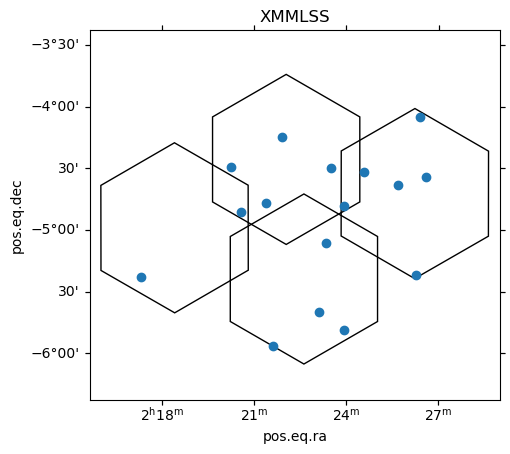

In [14]:
qsos_in_pfs = select_brightqsos(bright_tab, fieldname_in='XMMLSS')

Rough center for DEEP2-3: 23h29m02.6024s-0d02m34.894608s


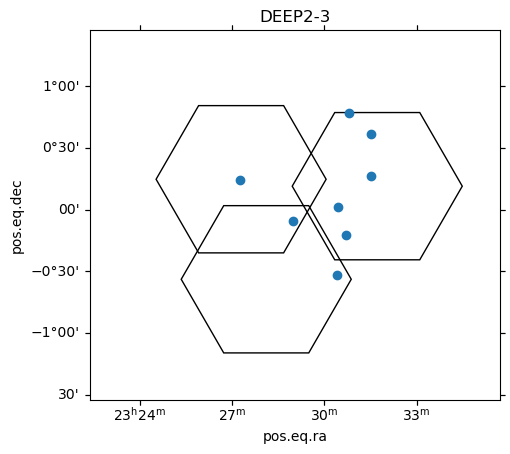

In [15]:
qsos_in_pfs = vstack([qsos_in_pfs,select_brightqsos(bright_tab, fieldname_in='DEEP2-3',all_pa=90.)]) # The DEEP2-3 pointings are at PA=90 deg 

Rough center for COSMOS: 10h00m25.6158s+2d06m28.86588s


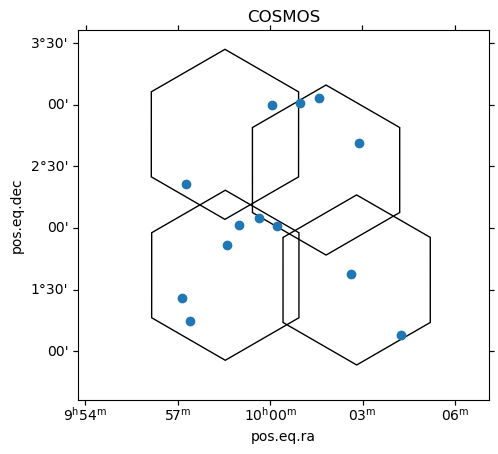

In [16]:
qsos_in_pfs = vstack([qsos_in_pfs,select_brightqsos(bright_tab, fieldname_in='COSMOS')])


In [17]:
qsos_in_pfs_nocoord = copy.copy(qsos_in_pfs)
qsos_in_pfs_nocoord.remove_column('coord')
qsos_in_pfs.pprint_all()

     sdssname                       coord                     z        gmag      rmag      imag   fieldname est_exptime
                                   deg,deg                                                                             
------------------ --------------------------------------- -------- --------- --------- --------- --------- -----------
021719.46-052305.3   34.331083992930054,-5.384812069372505    2.699 19.656738 19.371342  19.32647    XMMLSS    6.642302
022014.33-042917.2    35.05973764774192,-4.488112256004034    2.457 19.038404 18.955503 19.007404    XMMLSS   2.1264324
022034.52-045132.6   35.14387258611545,-4.8590632355646495    2.734 19.964972 19.808455 19.891132    XMMLSS   11.719397
022122.51-044658.8    35.34379526273842,-4.783002017976669    2.636 20.367102 20.040592 19.831936    XMMLSS   24.581556
022137.25-055628.6    35.40521306221583,-5.941284465987222    3.084  20.42595 20.112373 20.010386    XMMLSS   27.396008
022154.21-041458.6   35.475899448180776,

Sort by exposure time and plot the cumulative exposure plot

In [ ]:
sort_exptime = np.argsort(qsos_in_pfs_nocoord['est_exptime'])

qsos_in_pfs_nocoord[sort_exptime].pprint_all()

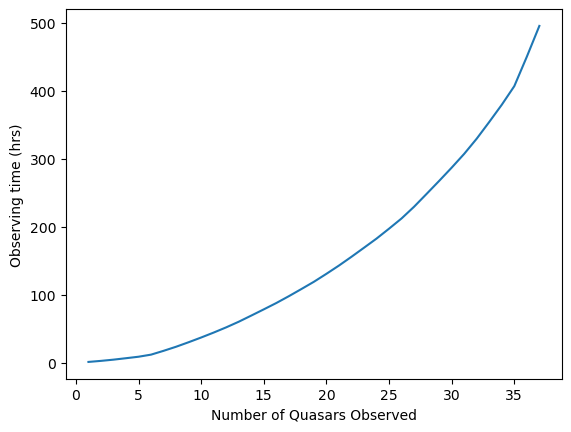

In [20]:
cum_exptime = np.cumsum(qsos_in_pfs['est_exptime'][sort_exptime])

fig, ax = plt.subplots()

ax.plot(np.arange(np.size(cum_exptime))+1., cum_exptime)
ax.set_xlabel('Number of Quasars Observed')
ax.set_ylabel('Observing time (hrs)')
plt.show()